# Experiment: UMAP All Conditions
Generate aggregate UMAP plots over all conditions:
1. `Truth` vs `Pred` global comparison
2. Colored by condition (with different markers for Truth/Pred)


In [8]:
from pathlib import Path
import pickle
import zlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image, display

try:
    import umap
except ImportError as exc:
    raise SystemExit("Missing dependency: umap-learn. Install with `pip install umap-learn`.") from exc

repo_root = Path.cwd()
if not (repo_root / "scripts").exists() and (repo_root.parent / "scripts").exists():
    repo_root = repo_root.parent


def _equal_sample_pair(pred: np.ndarray, truth: np.ndarray, seed: int) -> tuple[np.ndarray, np.ndarray]:
    if pred.ndim != 2 or truth.ndim != 2:
        raise ValueError("pred/truth must be 2D arrays")
    if pred.shape[1] != truth.shape[1]:
        raise ValueError("pred/truth feature dims mismatch")

    n = min(pred.shape[0], truth.shape[0])
    if n <= 0:
        return pred[:0], truth[:0]
    if pred.shape[0] == n and truth.shape[0] == n:
        return pred, truth

    rng = np.random.default_rng(seed)
    pred_idx = rng.choice(pred.shape[0], size=n, replace=False) if pred.shape[0] > n else np.arange(n)
    truth_idx = rng.choice(truth.shape[0], size=n, replace=False) if truth.shape[0] > n else np.arange(n)
    return pred[pred_idx], truth[truth_idx]


def _collect_gene_names(cond: str, item: dict, width: int) -> np.ndarray:
    genes = item.get("DE_name", None)
    if genes is None:
        return np.array([f"{cond}__g{i}" for i in range(width)], dtype=object)
    genes_arr = np.asarray(genes).astype(str, copy=False)
    if genes_arr.size != width:
        return np.array([f"{cond}__g{i}" for i in range(width)], dtype=object)
    return genes_arr


def _build_aggregate_frame(obj: dict, equal_sample: bool = False, seed: int = 24) -> tuple[pd.DataFrame, str]:
    rows = []
    cond_keys = sorted(obj.keys())
    gene_sets: list[set[str]] = []
    cache = {}

    for cond in cond_keys:
        item = obj[cond]
        if not isinstance(item, dict):
            continue
        pred = np.asarray(item.get("Pred", np.empty((0, 0), dtype=np.float32)))
        truth = np.asarray(item.get("Truth", np.empty((0, 0), dtype=np.float32)))
        if pred.ndim != 2 or truth.ndim != 2 or pred.shape[1] != truth.shape[1] or pred.shape[1] == 0:
            continue

        if equal_sample:
            cond_seed = seed + (zlib.crc32(cond.encode("utf-8")) % (2**31 - 1))
            pred, truth = _equal_sample_pair(pred, truth, cond_seed)
            if pred.shape[0] == 0:
                continue

        genes = _collect_gene_names(cond, item, pred.shape[1])
        gene_set = set(genes.tolist())
        gene_sets.append(gene_set)
        cache[cond] = (pred, truth, genes)

    if not cache:
        raise ValueError("no valid condition matrices for aggregate UMAP")

    gene_intersection = set.intersection(*gene_sets) if gene_sets else set()
    if len(gene_intersection) >= 2:
        feature_names = sorted(gene_intersection)
        mode = "intersection"
    else:
        feature_names = sorted(set.union(*gene_sets))
        mode = "union_impute"

    feat_idx = {g: i for i, g in enumerate(feature_names)}

    for cond in sorted(cache.keys()):
        pred, truth, genes = cache[cond]
        gene_pos = {g: i for i, g in enumerate(genes.tolist())}
        keep = [g for g in feature_names if g in gene_pos]
        if not keep:
            continue

        src_idx = np.array([gene_pos[g] for g in keep], dtype=int)
        dst_idx = np.array([feat_idx[g] for g in keep], dtype=int)

        truth_mat = np.full((truth.shape[0], len(feature_names)), np.nan, dtype=np.float32)
        pred_mat = np.full((pred.shape[0], len(feature_names)), np.nan, dtype=np.float32)
        truth_mat[:, dst_idx] = truth[:, src_idx]
        pred_mat[:, dst_idx] = pred[:, src_idx]

        rows.append(pd.DataFrame(truth_mat, columns=feature_names).assign(condition=cond, kind="Truth"))
        rows.append(pd.DataFrame(pred_mat, columns=feature_names).assign(condition=cond, kind="Pred"))

    if not rows:
        raise ValueError("failed to build aggregate matrix")

    df = pd.concat(rows, ignore_index=True)
    feat_cols = [c for c in df.columns if c not in {"condition", "kind"}]
    if mode == "union_impute":
        feat = df[feat_cols].to_numpy(dtype=np.float32, copy=True)
        col_mean = np.nanmean(feat, axis=0)
        inds = np.where(np.isnan(feat))
        feat[inds] = col_mean[inds[1]]
        df[feat_cols] = feat

    return df, mode


def _plot_aggregate(df: pd.DataFrame, out_dir: Path, seed: int, mode: str) -> None:
    feat_cols = [c for c in df.columns if c not in {"condition", "kind"}]
    x = df[feat_cols].to_numpy(dtype=np.float32, copy=False)
    if x.shape[0] < 3 or x.shape[1] < 2:
        raise ValueError("aggregate matrix too small for UMAP")

    n_neighbors = max(2, min(25, x.shape[0] - 1))
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=0.3,
        random_state=seed,
    )
    emb = reducer.fit_transform(x)
    df_plot = df.copy()
    df_plot["umap1"] = emb[:, 0]
    df_plot["umap2"] = emb[:, 1]

    plt.figure(figsize=(7, 5))
    for kind, color in (("Truth", "#1f77b4"), ("Pred", "#ff7f0e")):
        sel = df_plot["kind"] == kind
        plt.scatter(
            df_plot.loc[sel, "umap1"],
            df_plot.loc[sel, "umap2"],
            s=12,
            alpha=0.65,
            label=f"{kind} (n={sel.sum()})",
            c=color,
        )
    plt.title(f"All Conditions | Truth vs Pred | UMAP ({mode})")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(alpha=0.25)
    plt.legend()
    plt.tight_layout()
    out_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_dir / "all_conditions_truth_vs_pred_umap.png", dpi=160)
    plt.close()

    conds = sorted(df_plot["condition"].unique().tolist())
    cmap = plt.cm.get_cmap("tab20", max(len(conds), 1))
    cond_color = {c: cmap(i) for i, c in enumerate(conds)}
    plt.figure(figsize=(8, 6))
    for kind, marker in (("Truth", "o"), ("Pred", "x")):
        sub = df_plot[df_plot["kind"] == kind]
        for cond in conds:
            sel = sub["condition"] == cond
            if not sel.any():
                continue
            plt.scatter(
                sub.loc[sel, "umap1"],
                sub.loc[sel, "umap2"],
                s=12,
                alpha=0.6,
                marker=marker,
                c=[cond_color[cond]],
            )
    plt.title(f"All Conditions | Colored by Condition | UMAP ({mode})")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.savefig(out_dir / "all_conditions_by_condition_umap.png", dpi=160)
    plt.close()


In [9]:
# Configuration
pkl_path = repo_root / "artifacts" / "results" / "adamson" / "trishift_adamson_1.pkl"
out_dir = repo_root / "artifacts" / "results" / "adamson" / "umap_plots"
out_dir.mkdir(parents=True, exist_ok=True)
seed = 24
equal_sample = True  # Sample Truth/Pred to equal counts


In [10]:
with pkl_path.open("rb") as f:
    obj = pickle.load(f)

agg_df, mode = _build_aggregate_frame(obj, equal_sample=equal_sample, seed=seed)
print("Aggregate mode:", mode)
print("Aggregate shape:", agg_df.shape)


Aggregate mode: union_impute
Aggregate shape: (10200, 81)


d:\conda_envs\scouter\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\16523\AppData\Local\Temp\ipykernel_29228\3927427887.py:160: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(len(conds), 1))


Saved: e:\CODE\trishift\artifacts\results\adamson\umap_plots\all_conditions_truth_vs_pred_umap.png
Saved: e:\CODE\trishift\artifacts\results\adamson\umap_plots\all_conditions_by_condition_umap.png


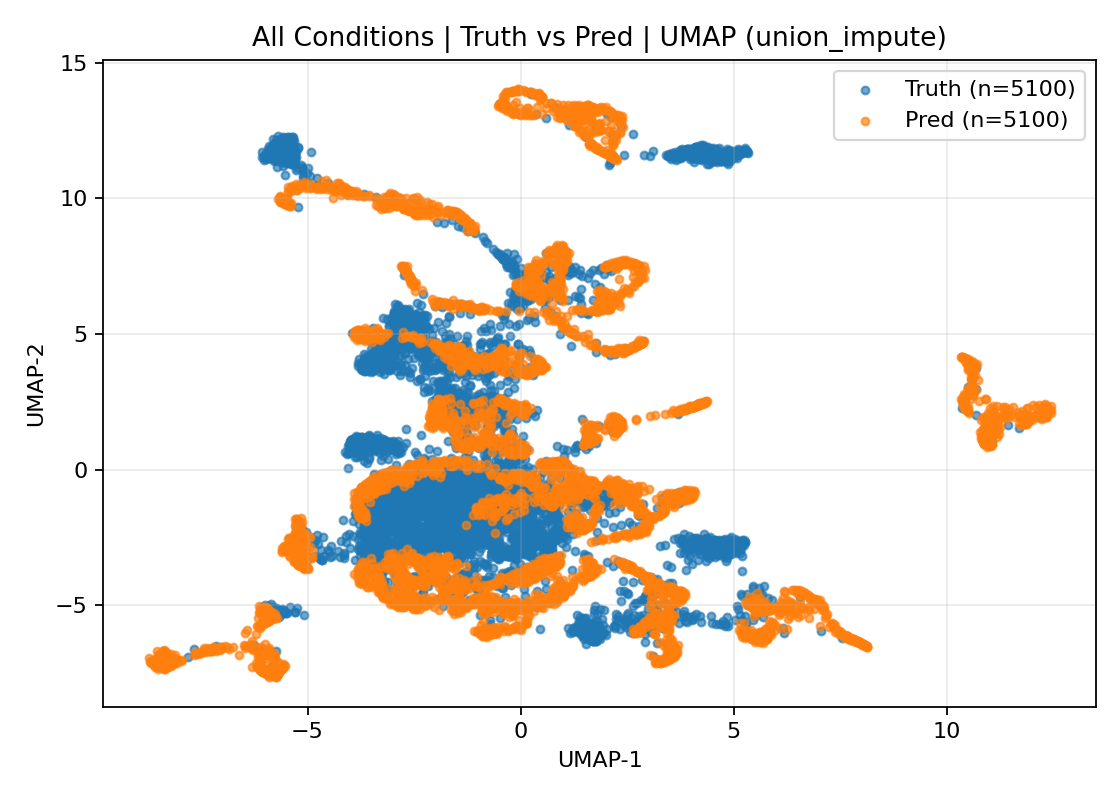

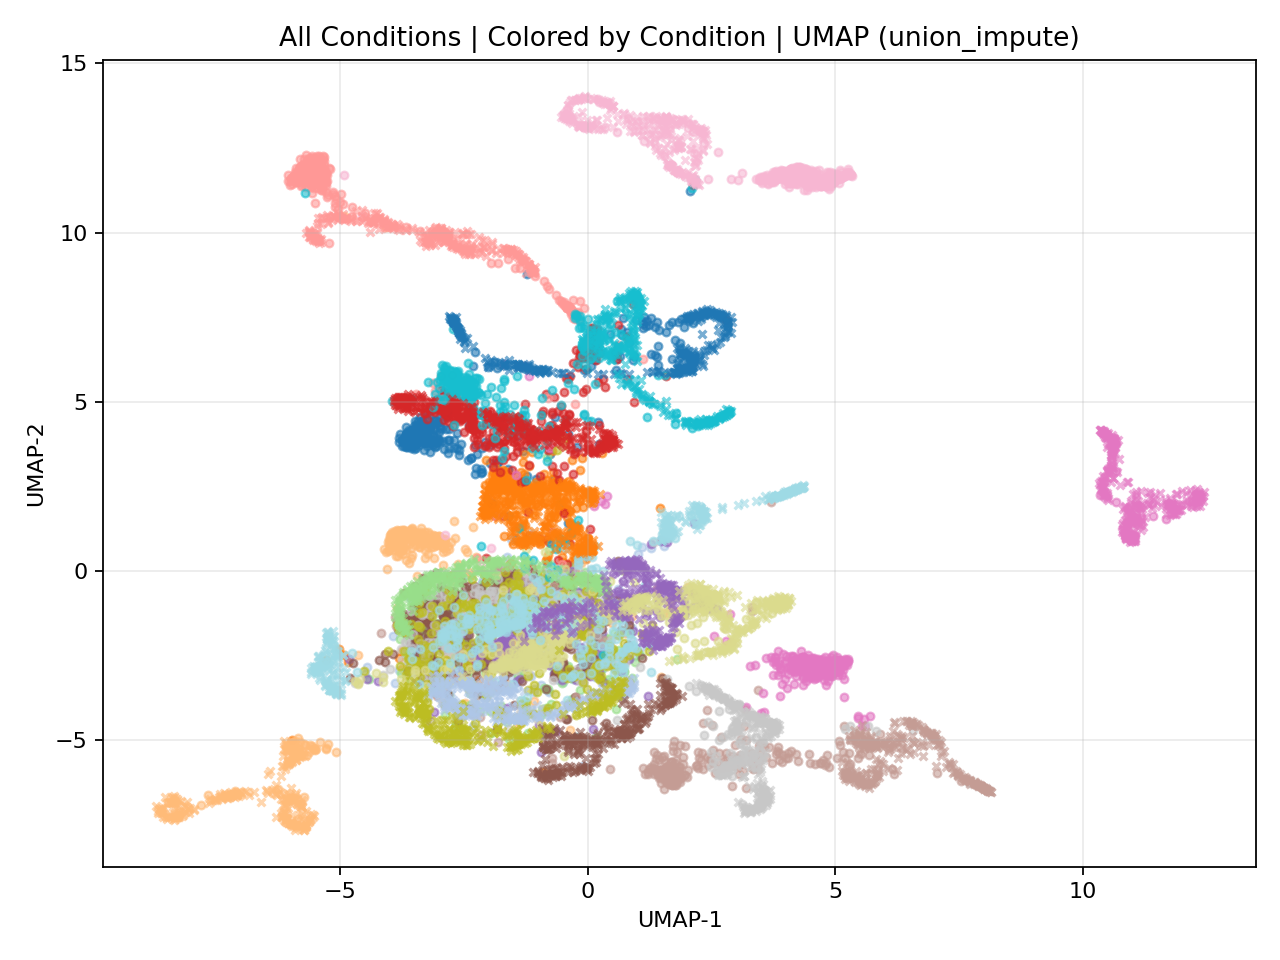

In [11]:
_plot_aggregate(agg_df, out_dir=out_dir, seed=seed, mode=mode)
img1 = out_dir / "all_conditions_truth_vs_pred_umap.png"
img2 = out_dir / "all_conditions_by_condition_umap.png"
print("Saved:", img1)
print("Saved:", img2)
display(Image(filename=str(img1)))
display(Image(filename=str(img2)))
        
